In [188]:
import pandas
import sqlalchemy
from matplotlib import pyplot
import sklearn


%matplotlib inline

In [189]:
con = sqlalchemy.create_engine("""sqlite:///tester.db""")
data = pandas.read_sql_query("""SELECT * FROM zaif_ticker""", con )
del data["currency_pair"]

In [190]:
data.index = pandas.to_datetime(data.date)

In [191]:
resampled = data.resample("10s").mean().dropna()

In [192]:
# dataset Creation
training_data = resampled[:"2017-06-30 17:10:00"]
test_data = resampled["2017-06-30 17:42:00":]

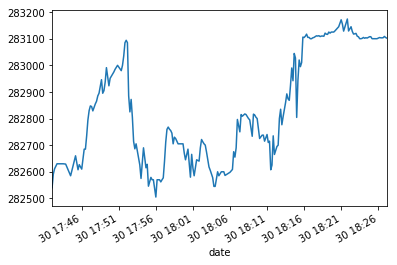

In [193]:
test_data["price"].plot()

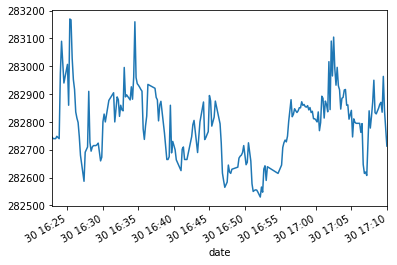

In [194]:
training_data["price"].plot()

In [170]:
rolling_diff_1M = training_data.rolling(6).mean()["price"].diff().dropna()
rolling_diff_5M = training_data.rolling(30).mean()["price"].diff().dropna()
rolling_diff_10M = training_data.rolling(60).mean()["price"].diff().dropna()

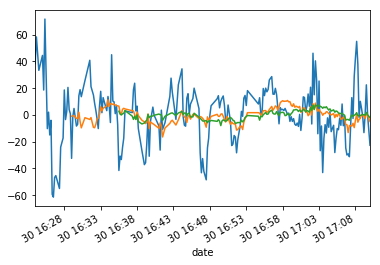

In [171]:
rolling_diff_1M.plot()
rolling_diff_5M.plot()
rolling_diff_10M.plot()

In [183]:
rolling_diff_df = pandas.concat([rolling_diff_1M, rolling_diff_5M, rolling_diff_10M], axis=1).dropna()
rolling_diff_df.columns = ["1M", "5M", "10M"]


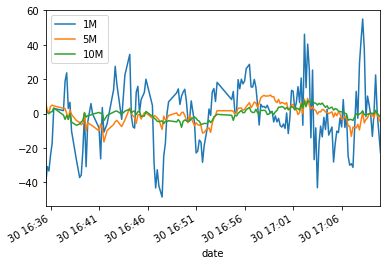

In [185]:
rolling_diff_df.plot()

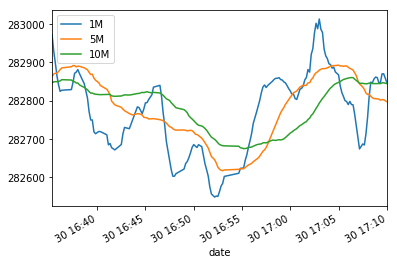

In [187]:
rolling_1M = training_data.rolling(6).mean()["price"].dropna()
rolling_5M = training_data.rolling(30).mean()["price"].dropna()
rolling_10M = training_data.rolling(60).mean()["price"].dropna()

rolling_df = pandas.concat([rolling_1M, rolling_5M, rolling_10M], axis=1).dropna()
rolling_df.columns = ["1M", "5M", "10M"]

rolling_df.plot()

In [197]:
rolling_df.head(3).to_dict()

{'10M': {Timestamp('2017-06-30 16:35:20'): 282846.5542856449,
  Timestamp('2017-06-30 16:35:30'): 282849.31539675605,
  Timestamp('2017-06-30 16:35:40'): 282849.89873008936},
 '1M': {Timestamp('2017-06-30 16:35:20'): 282971.85019841272,
  Timestamp('2017-06-30 16:35:30'): 282930.29464285716,
  Timestamp('2017-06-30 16:35:40'): 282899.52083333331},
 '5M': {Timestamp('2017-06-30 16:35:20'): 282863.28952367074,
  Timestamp('2017-06-30 16:35:30'): 282869.81174589298,
  Timestamp('2017-06-30 16:35:40'): 282871.70222208346}}

In [198]:
# Detect Golden Cross / Dead Cross
def golden_detect(latest_3_df: pandas.DataFrame) -> bool:
    """
    >>> df = {'10M': {Timestamp('2017-06-30 16:35:20'): 282846.5542856449,
  Timestamp('2017-06-30 16:35:30'): 282849.31539675605,
  Timestamp('2017-06-30 16:35:40'): 282849.89873008936},
 '1M': {Timestamp('2017-06-30 16:35:20'): 282971.85019841272,
  Timestamp('2017-06-30 16:35:30'): 282930.29464285716,
  Timestamp('2017-06-30 16:35:40'): 282899.52083333331},
 '5M': {Timestamp('2017-06-30 16:35:20'): 282863.28952367074,
  Timestamp('2017-06-30 16:35:30'): 282869.81174589298,
  Timestamp('2017-06-30 16:35:40'): 282871.70222208346}}
    >>> df = pandas.DataFrame.from_dict(df)
    >>> golden_detect(df)
  """
    